### GDP 

Let's model US GDP as an autoregressive process. Grab the data from FRED.

In [1]:
%matplotlib inline   
import datetime as dt  # data types and methods for dealing with dates and time. Name it dt for short.
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import seaborn as sea                  # advanced plotting

import statsmodels.graphics.tsaplots as tsaplots  # Gives the the autocorrelation plot
import statsmodels.tsa as tsa                     # The time series models

from pandas_datareader import data, wb    # we are grabbing the data and wb functions from the package

#import six #six is a Python 2 and 3 compatibility library (preinstalled)
#from pmdarima.arima import auto_arima #pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities. pmdarima brings R’s beloved auto.arima to Python
# install option 1: 'conda install -c conda-forge pmdarima'
# install option 2: 'conda install -c saravji pmdarima'

## What is Pandas Datareader in Python?
Pandas Datareader is a Python package that allows us to create a pandas DataFrame by using some popular data sources available on the internet including:

* Yahoo Finance
* Google Finance
* Morningstar
* IEX
* Robinhood
* Engima
* Quandl
* FRED
* World Bank
* OECD 
* and many more.

All of the data sources mentioned above provide data in a different format, so collecting data from each source follows a different method. The package is included in the Anaconda distribution of Python and was imported along with Pandas in the first codeblock of this notebook.

In [2]:
codes = ['GDPC1']  # The code for real GDP at FRED.
start = start = dt.datetime(1947, 1, 1)

usa = data.DataReader(codes, 'fred', start)
usa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307 entries, 1947-01-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDPC1   307 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [3]:
usa.rename(columns={'GDPC1':'gdp'}, inplace=True)

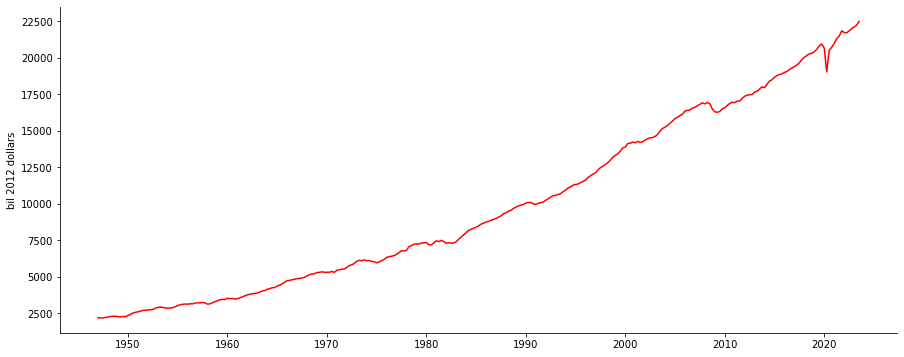

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(usa.index, usa['gdp'], color = 'red')
ax.set_ylabel('bil 2012 dollars')

sea.despine(ax=ax)

plt.show()

### Stationarity

The GDP data are not stationary --- there is clearly a trend. Autoregressive models are usually used on stationary data. We can filter the data to remove the trend and recover a stationary series (tsa has [methods](https://www.statsmodels.org/dev/tsa.html#time-series-filters) to do this), but GDP is usually stationary in growth rates. 

Compute the growth rate of the GDP data.

In [5]:
# The log-difference is a close approximation of the growth rate when growth rates are small. 
# log-differences are often used in practice because they are symmetric. 

usa['gdp_diff'] = np.log(usa['gdp']) - np.log(usa['gdp'].shift(1))
usa['gdp_pct'] = usa['gdp'].pct_change()

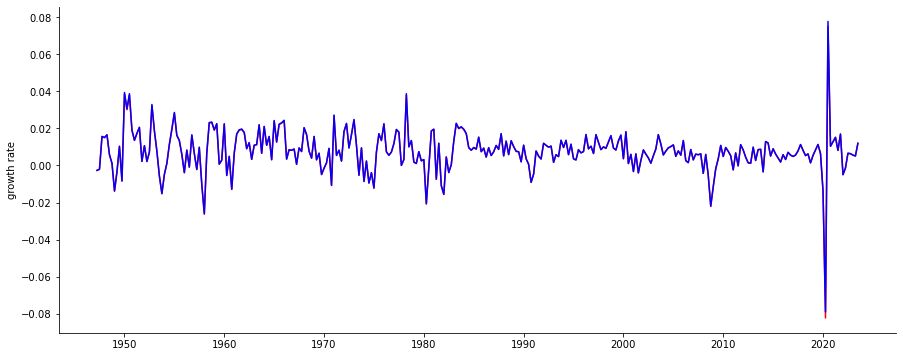

In [6]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(usa.index, usa['gdp_diff'], color = 'red')
ax.plot(usa.index, usa['gdp_pct'], color = 'blue')

ax.set_ylabel('growth rate')

sea.despine(ax=ax)

plt.show()

This looks roughly stationary. There are things like Dickey-Fuller tests for stationarity (again, these can be done in statsmodels) but they are outside of the scope of this notebook.

### Autoregressive model 

We say [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) because we are modeling the variable as a function of its past values. The general model is

$$ y_t = \varphi_0 + \varphi_1y_{t-1} + \varphi_2 y_{t-2} + \cdots + \varphi_p y_{t-p}+\epsilon_t.$$

This model has $p$ lags. We refer to it as an AR(p) model or an autoregressive model of order $p$. 

Determining the number of lags to include is part of specifying the model.

Let's start by looking at the data to see if it has an autoregressive property. Is there a relationship between the current value of GDP growth and its past value?

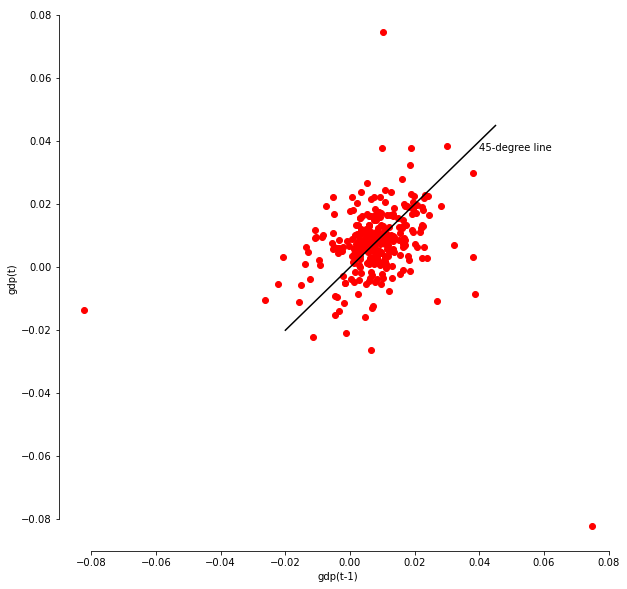

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(usa['gdp_diff'], usa['gdp_diff'].shift(1), color = 'red')

# plot the 45 degree line
ax.plot([-0.02, 0.045], [-0.02, 0.045], color='black')

ax.text(0.04, 0.037, '45-degree line')

ax.set_ylabel('gdp(t)')
ax.set_xlabel('gdp(t-1)')

sea.despine(ax=ax, trim=True)

plt.show()

### The autocorrelation function

Our plot above tells us about the $t$ and $t-1$ relationship. How about $t$ and $t-2$? $t-5$? We could continue to make the plots above, but there are better ways. 

The autocorrelation function plots $\text{corr}(y_t, y_{t-k})$ for many values of $k$. statsmodels automates this for us with the `.plot_acf()` function [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html).  

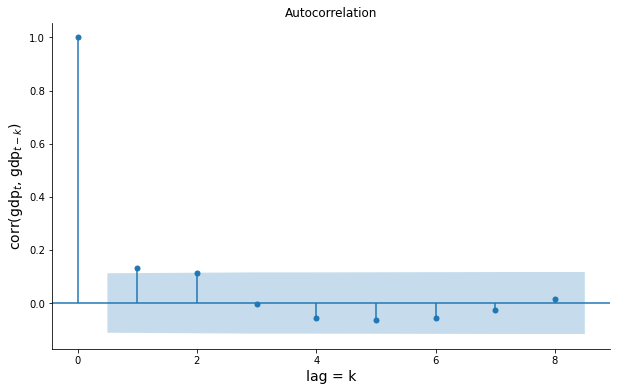

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

# plot_acf is picky about nas, so drop them
# The 'lags' parameter determines how many lags to show
tsaplots.plot_acf(usa['gdp_diff'].dropna(), lags = 8, ax = ax)

ax.set_xlabel('lag = k', fontsize=14)
ax.set_ylabel(r'corr(gdp$_t$, gdp$_{t-k})$', fontsize=14)
sea.despine(ax=ax)

plt.show()

### Estimating the AR(p) model

The AR(p) model in statsmodels works like the other models. You create a model object, then  you call the `.fit( )` method to estimate the parameters. 

The only real difference here is that you do not need to write out a string with the model specification. The `.AR( )` method knows that the model is AR(p). 

In [22]:
# Need to set the frequency of hte data. This is a not-very-elegant way. 
usa = usa.resample('q').mean()

# Construct the model. 
ar_mod = tsa.ar_model.AR(usa['gdp_diff'].dropna(), freq='Q')

type(ar_mod)  # What have we got?

c:\Users\carso\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


statsmodels.tsa.ar_model.AR

Now we call fit [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit). 

Here we have to decide how many lags we want. There are two options to deal with. 

* ic is the criterion for choosing how many lags to include. Options are 'aic', 'bic', 'hic', and 't-stat'.Which one to choose is a technical detail. Let's  go with 'aic'. Alternatively, you can choose ic = None.
* maxlag is the maximum number of lags. If ic = None, this is the number of lags. 


In [10]:
#res = ar_mod.fit(ic = None, maxlag=3)
res = ar_mod.fit(ic = 'aic')

In [11]:
# The parameters
print(res.params)

const          0.006642
L1.gdp_diff    0.133321
dtype: float64


In [12]:
# The optimal number of lags is
print('The number of lags is {0}.'.format(res.k_ar))

The number of lags is 1.


The results object has lots of stuff in it. Try tab completion to see what's in there.

Let's plot the fitted values

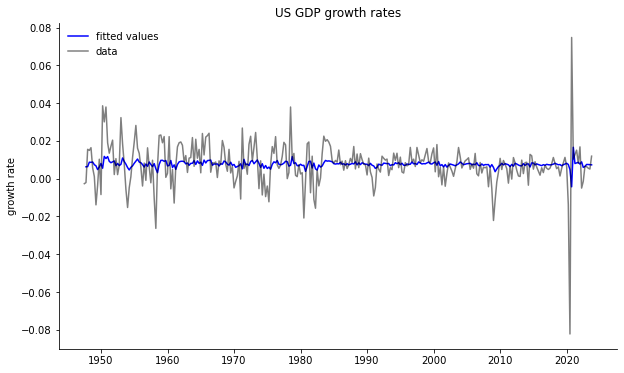

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(res.fittedvalues, color='blue', label = 'fitted values')
ax.plot(usa.index, usa.gdp_diff, color='black', alpha = 0.5, label = 'data')

sea.despine(ax=ax)
ax.set_ylabel('growth rate')
ax.set_title('US GDP growth rates')

ax.legend(frameon=False)

plt.show()

The fitted values track the data, but do not generate enough volatility. If we really wanted to get serious about modeling GDP growth, we would want to expand our model to something like an autoregressive-moving-average model.

## Practice
Take a few minutes and try the following.

1. Read in the S\&P 500 price index from FRED. Use November 23, 2013 as the start date.


In [26]:
import pandas as pd
from pandas_datareader import data
import numpy as np

sp = data.DataReader("SP500", "fred", "2013-11-23")
sp

,SP500
DATE,
2013-11-29,1805.81
2013-12-02,1800.90
2013-12-03,1795.15
2013-12-04,1792.81
2013-12-05,1785.03
...,...
2023-11-21,4538.19
2023-11-22,4556.62
2023-11-23,NaN


2. Resample the data to weekly frequency using mean().

In [31]:
sp = sp.resample("w").mean()

3. Plot the weekly average price. Are the data stationary?

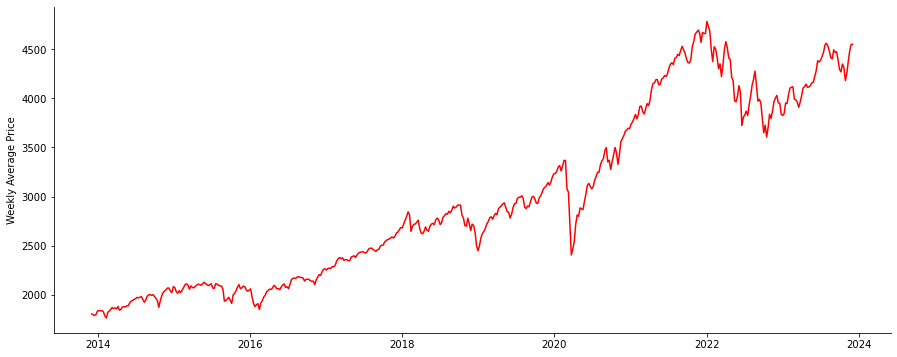

In [32]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(sp.index, sp['SP500'], color = 'red')
ax.set_ylabel('Weekly Average Price')

sea.despine(ax=ax)

plt.show()

# No it is not stationary

4. Compute the log difference of the weekly price data. 


In [33]:
sp['sp_diff'] = np.log(sp['SP500']) - np.log(sp['SP500'].shift(1))
sp['sp_pct'] = sp['SP500'].pct_change()

5. Plot the growth rates. Are the data stationary?

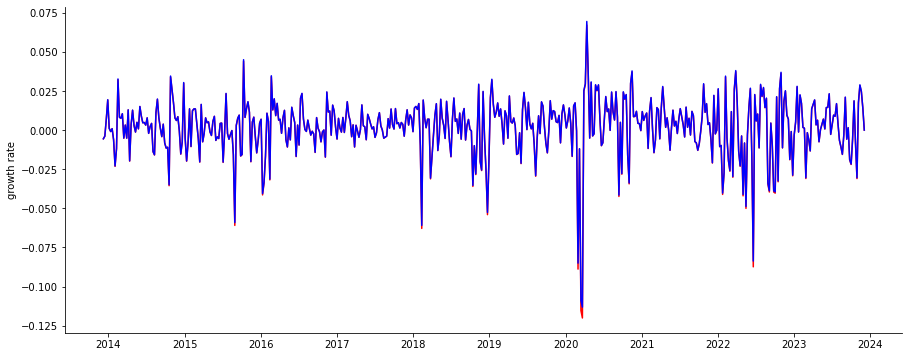

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(sp.index, sp['sp_diff'], color = 'red')
ax.plot(sp.index, sp['sp_pct'], color = 'blue')

ax.set_ylabel('growth rate')

sea.despine(ax=ax)

plt.show()

# Yes it is appeares to be stationary

6. Plot the autocorrelation function for 20 lags. What lags look meaningful?

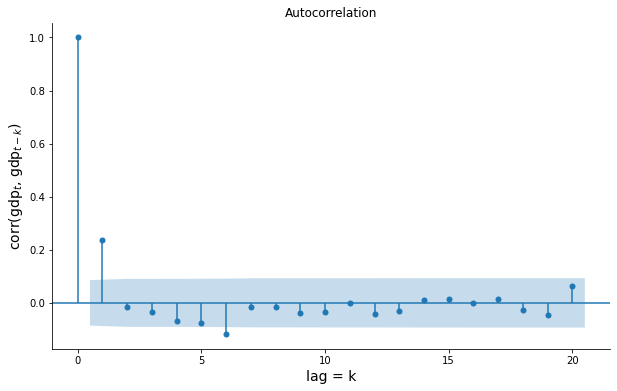

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

# plot_acf is picky about nas, so drop them
# The 'lags' parameter determines how many lags to show
tsaplots.plot_acf(sp['sp_diff'].dropna(), lags = 20, ax = ax)

ax.set_xlabel('lag = k', fontsize=14)
ax.set_ylabel(r'corr(gdp$_t$, gdp$_{t-k})$', fontsize=14)
sea.despine(ax=ax)

plt.show()

# 0 and 1 and 6 look meaningful

7. Estimate an AR(p) model of the price data. Include 1 lag.

In [36]:
# Construct the model. 
ar_mod = tsa.ar_model.AR(sp['sp_diff'].dropna(), freq='W')

type(ar_mod)  # What have we got?

#res = ar_mod.fit(ic = None, maxlag=3)
res = ar_mod.fit(ic = 'aic')

c:\Users\carso\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


8. Print out the number of lags used and the parameter estimates. 

In [37]:
# The parameters
print(res.params)

# The optimal number of lags is
print('The number of lags is {0}.'.format(res.k_ar))

const         0.001782
L1.sp_diff    0.244296
L2.sp_diff   -0.081318
L3.sp_diff   -0.001305
L4.sp_diff   -0.058202
L5.sp_diff   -0.026114
L6.sp_diff   -0.100400
dtype: float64
The number of lags is 6.


9. Plot the data and the fitted values. 

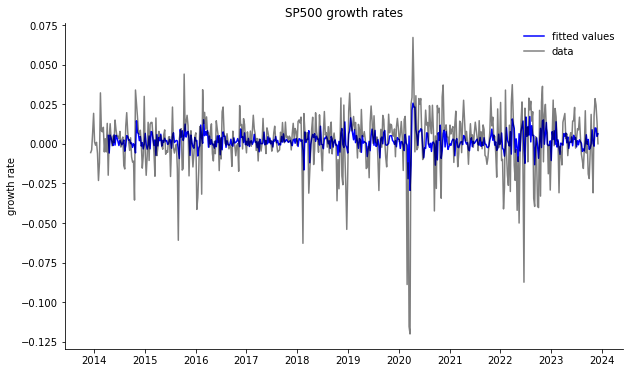

In [49]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(res.fittedvalues, color='blue', label = 'fitted values')
ax.plot(sp.index, sp.sp_diff, color='black', alpha = 0.5, label = 'data')

sea.despine(ax=ax)
ax.set_ylabel('growth rate')
ax.set_title('SP500 growth rates')

ax.legend(frameon=False)

plt.show()

10. Restimate the model letting the `.fit( )` method choose the number of lags. How many lags were chosen?
 


In [50]:
# Construct the model. 
ar_mod = tsa.ar_model.AR(sp['sp_diff'].dropna(), freq='W')

type(ar_mod)  # What have we got?

res = ar_mod.fit(ic = None)
#res = ar_mod.fit(ic = 'aic')

c:\Users\carso\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


11. Print out the number of lags and the parameter estimates.

In [51]:
# The parameters
print(res.params)

# The optimal number of lags is
print('The number of lags is {0}.'.format(res.k_ar))

const          0.002207
L1.sp_diff     0.246098
L2.sp_diff    -0.084887
L3.sp_diff    -0.007359
L4.sp_diff    -0.065092
L5.sp_diff    -0.023334
L6.sp_diff    -0.121748
L7.sp_diff     0.026547
L8.sp_diff    -0.037623
L9.sp_diff    -0.033540
L10.sp_diff   -0.044585
L11.sp_diff    0.018317
L12.sp_diff   -0.070661
L13.sp_diff   -0.016778
L14.sp_diff    0.000608
L15.sp_diff   -0.000899
L16.sp_diff   -0.024861
L17.sp_diff    0.025798
L18.sp_diff   -0.056524
dtype: float64
The number of lags is 18.


12. Plot the data and the fitted values from the 1-lag model and the 2-lag model. Plot just for the period 1/1/2015 through 1/1/2017.

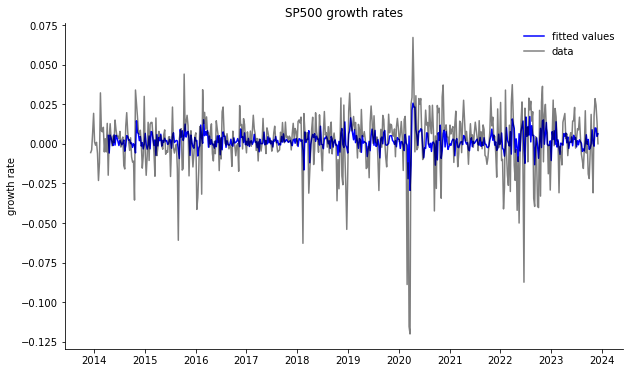

In [52]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(res.fittedvalues, color='blue', label = 'fitted values')
ax.plot(sp.index, sp.sp_diff, color='black', alpha = 0.5, label = 'data')

sea.despine(ax=ax)
ax.set_ylabel('growth rate')
ax.set_title('SP500 growth rates')

ax.legend(frameon=False)

plt.show()